In [2]:
from openai import OpenAI
import json


In [3]:
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

In [4]:
schema = {
    "type": "json_schema",
    "json_schema": {
        "name": "receipt",
        "schema": {
            "type": "object",
                "properties": {
                    "category": {"type": "string"},
                    "date": {"type": "string"},
                    "total": {"type": "integer"},
                },
                "required": ["category", "total"]
                },
            }
        }


In [65]:
from pydantic import BaseModel
class Receipt(BaseModel):
    category: str
    date: str
    total: int

In [61]:
system_prompt = """You are a helpful assistant trained to extract structured information from unstructured text. Your task is to process scanned receipt text and output JSON object with three require pieces of information.

The model you are generating should have three fields:
1. **category**: The spending category which belongs to food, shopping, grocery, medical and misca
2. **date**: The date the receipt was issued in the format "MM/DD/YYYY".
3. **total**: The total amount spent, formatted as a number (e.g., "25", "123.45").

### Instructions:
- Identify the spending category, date, and total amount. 
- If any information is missing, leave the corresponding field blank.
- Ensure the output strictly adheres to the following JSON Schema:
  schema = {
    "type": "object",
    "properties": {
        "category": {"type": "string"},
        "date": {"type": "string"},
        "Total": {"type": "integer"}
    },
    "required": ["category", "amount"]
  }
- Output only the JSON Schema as the example showed
- DO NOT INCLUDE ANY COMMENTATION OR CONVERSATION
- DO NOT INCLUDE "Here is the extracted information in JSON format:..." in output

### Example:
- Input:
Boiling Point
123 Alexander Ave, San Jose, CA 95112
01/12/2024
1. Seafood Hot Pot              $15.99
2. Beef Hot Pot                 $17.99
Subtotal                        $33.98
Tax                             $3.4
Total                           $37.38

- Output:
{
  "category": "Food",
  "date": "01/12/2024",
  "Total": 37.38
}
"""

In [7]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
def preprocess_image(image_path):
    dpi = 300
    img = Image.open(image_path)
    img.info['dpi'] = (dpi, dpi)
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #opt_thr, img_ = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    return gray

OCR 1

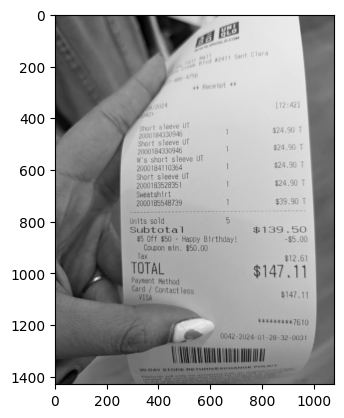

In [8]:
processed_img1 = preprocess_image('receipt2.png')
plt.imshow(processed_img1, cmap = 'gray')

OG IMAGE

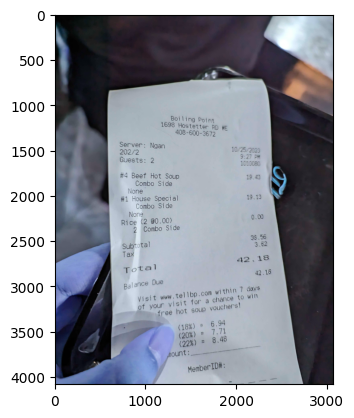

In [49]:
im = cv2.imread('receipt1.jpg')
plt.imshow(im)

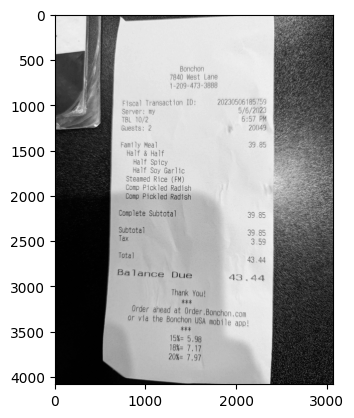

In [79]:

plt.imshow(preprocess_image('receipt6.jpg'),cmap = 'gray')

In [83]:
text = pytesseract.image_to_string(preprocess_image('receipt5.png'), config = '--oem 1 --psm 6')
print(text)

siamese Street Thal Restaurant
3236 Pacific Ave
stockton, CA 95204
(209) 466-0130
Www siamesestreetthal com
Dining Chk# 66
Tablet 12 _ ee
server. Kalee 04/29/2023, 08:13 PM
3 Thai \ce Tea 18 00
3 Water 0.00
4 Sweet Chili Wings 47.50
Jasmine Rice
4 Green Curry 47.50
Beef
Medium
Jasmine Rice
4 Pad Thai 45.00
Pork
4 Pad Thai 45.00
Beef
Medium
Sub Total 83.00 ;
Sale Tax 7.47
Total Due F500 47
Gratuity Suggestion
180% = $13.57
Soa $16.28
20.00% = $18.09
THANG OUI



In [46]:
user_prompt = '''Below is the receipt that you need to extract information from.
{}'''

In [84]:
response = client.beta.chat.completions.parse(
    model="QuantFactory/Meta-Llama-3-8B-Instruct-GGUF/Meta-Llama-3-8B-Instruct.Q4_0.gguf",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt.format(text)}
    ],
    max_tokens = 50,
    temperature= 0.1,
    response_format= schema
)

In [85]:
results = json.loads(response.choices[0].message.content)
print(json.dumps(results, indent=2))

{
  "category": "Food",
  "date": "04/29/2023",
  "Total": 90.47
}
